<a href="https://colab.research.google.com/github/AndreaCamilloni/Online-learning-application-21-22/blob/main/ola14_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class env:
  def __init__(self,probs,prices):
    self.prices = prices
    self.probs=probs
  
  def round(self, arm_pulled):
    conv = np.random.binomial(n=1, p=self.probs[arm_pulled])
    reward = conv*self.prices[arm_pulled]
    return reward
  

In [ ]:
class learner:
  def __init__(self,n_arms):
    self.t = 0
    self.n_arms = n_arms
    self.rewards = []
    self.reward_per_arm = [[] for _ in range(n_arms)]

  def reset(self):
    self.__init__(self.n_arms, self.prices)
  def act(self):
    pass
  
  def update(self, arm_pulled, reward):
    self.t += 1
    self.rewards.append(reward)
    self.reward_per_arm[arm_pulled].append(reward)

In [ ]:
class ucb(learner):
  def __init__(self,n_arms, prices):
    super().__init__(n_arms)
    self.means = np.zeros(n_arms)
    self.widths = np.array([np.inf for _ in range(n_arms)]) #we set them inittialy to +infinite, so we can explore all the initial bound
    self.prices = prices
  
  def act(self):
    idx = np.argmax((self.means + self.widths)*self.prices) #select the arm w/ high confidence bound
    return idx

  def update(self, arm_pulled, reward):
    reward = reward>0
    super().update(arm_pulled, reward) 
    self.means[arm_pulled] = np.mean(self.reward_per_arm[arm_pulled])
    for idx in range(self.n_arms):
      n = len(self.reward_per_arm[idx])
      if n>0:
        self.widths[idx] = np.sqrt(2*np.log(self.t)/n)
      else:
        self.widths[idx] = np.inf
  
#we use the upper confidence bound for inequality

In [ ]:
p = [0.5, .1, .2, .9]
prices = [100, 400, 600, 60]

pricing_env = env(p,prices)
ag1 = ucb(len(p), prices)
T = 1000
opt = np.max([a*b for a,b in zip(p, prices)])
N_exp = 50
R = []

for _ in range(N_exp):
  instant_regret = []
  ag1.reset()
  for t in range(T):
    pulled_arm = ag1.act()
    rew = pricing_env.round(pulled_arm)
    ag1.update(pulled_arm, rew)
    instant_regret.append(opt - rew)
  cumulative_regret = np.cumsum(instant_regret)
  R.append(cumulative_regret)
R = np.array(R)
mean_R = np.mean(R, axis = 0)
std_dev = np.std(R, axis=0)/np.sqrt(N_exp)

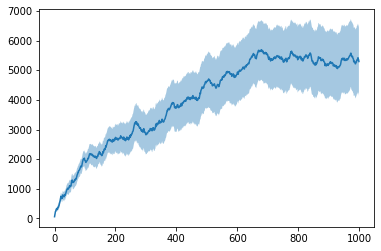

In [ ]:
plt.plot(mean_R)
plt.fill_between(range(T),mean_R-std_dev, mean_R+std_dev, alpha=0.4)

# 2nd Lab
(non stationarity) 

In [ ]:
class non_stat_env:
    def __init__(self, n_arms, proba_matrix, horizon):
        self.n_arms = n_arms
        self.proba_matrix = proba_matrix
        self.horizon = horizon
        self.n_changes = len(proba_matrix)
        self.inner_horizon = self.horizon // self.n_changes
        self.t = 0
        self.phase = 0

    def round(self, pulled_arm):
        if self.t > (self.phase + 1) * self.inner_horizon:
            self.phase = min(self.phase + 1, self.n_changes - 1)
        reward = np.random.binomial(n=1, p=self.proba_matrix[self.phase, pulled_arm])
        self.t += 1
        return reward


In [ ]:
class learner:
    def __init__(self, n_arms):
        self.t = 0
        self.n_arms = n_arms
        self.rewards = []
        self.reward_per_arm = [[] for _ in range(n_arms)]
        self.pulled = []

    def act(self):
        pass

    def update(self, arm_pulled, reward):
        self.t += 1
        self.rewards.append(reward)
        self.reward_per_arm[arm_pulled].append(reward)
        self.pulled.append(arm_pulled)


In [ ]:
class SW_TS(learner):
    def __init__(self, n_arms, window_size):
        super().__init__(n_arms)
        self.n_arms = n_arms
        self.window_size = window_size
        self.alphas = np.ones(self.n_arms)
        self.betas = np.ones(self.n_arms)
        self.t = 0

    def reset(self):
        self.__init__(self.n_arms, self.window_size)

    def update(self, pulled_arm, rewrad):
        super().update(pulled_arm, rewrad)
        for arm_idx in range(self.n_arms):
            n_samples = np.sum(np.array(self.pulled[-self.window_size:]) == arm_idx)
            if n_samples == 0:
                n_sold = 0
            else:
                n_sold = np.sum(self.reward_per_arm[arm_idx][-n_samples:])
            self.alphas[arm_idx] = n_sold + 1
            self.betas[arm_idx] = n_samples - n_sold + 1
            assert self.betas[arm_idx] > 0, (arm_idx, self.pulled[-self.window_size:], n_sold)

    def act(self):
        samples = [np.random.beta(a=self.alphas[i], b=self.betas[i]) for i in range(self.n_arms)]
        return np.argmax(samples)


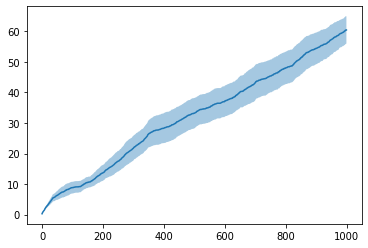

In [ ]:
p = np.array([[0.5, 0.4, 0.3, 0.2],
              [0., 0.5, 0.2, 0.3],
              [0.3, 0.2, 0.4, 0.6]])

T = 1000
n_arms = p.shape[1]
env = non_stat_env(n_arms, p, T)
window_size = 4 * int(np.sqrt(T))
ag1 = SW_TS(n_arms, window_size)
opt = np.max(p, axis=1)
N_exp = 5

R = []
for _ in range(N_exp):
    instant_regret = []
    ag1.reset()
    for t in range(T):
        pulled_arm = ag1.act()
        rew = env.round(pulled_arm)
        ag1.update(pulled_arm, rew)
        phase = env.phase
        instant_regret.append(opt[phase] - p[phase, pulled_arm])
    cumulative_regret = np.cumsum(instant_regret)
    R.append(cumulative_regret)
mean_R = np.mean(R, axis=0)
std_dev = np.std(R, axis=0) / np.sqrt(N_exp)

plt.plot(mean_R)
plt.fill_between(range(T), mean_R - std_dev, mean_R + std_dev, alpha=0.4)